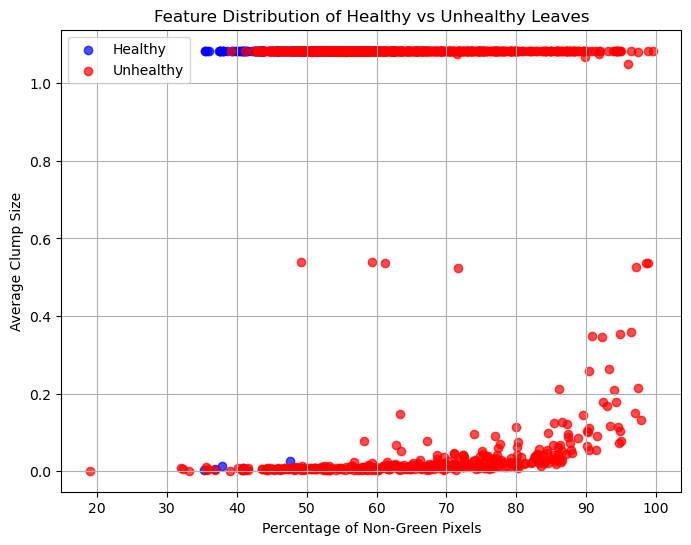

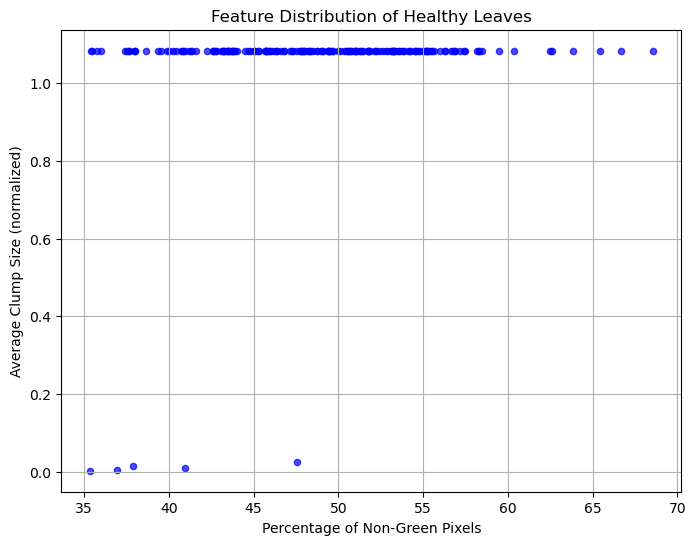

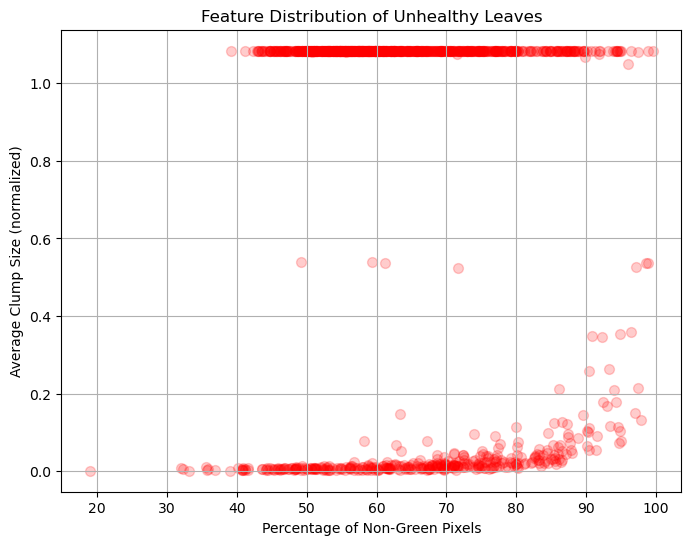

In [1]:
import os 
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
#import ace_tools as tools 

data_path = "../CNNExpirement/dataset"  
unhealthy_path = os.path.join(data_path, "Strawberry__healthy")
healthy_path = os.path.join(data_path, "Strawberry___Leaf_scorch") 

# Extract [x1, x2] as feature vector where 
# x1: %of non green and x2: average density of non green pixels
def get_features(image_path):  
    image = cv2.imread(image_path) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_green = np.array([25, 40, 40]) 
    upper_green = np.array([90, 255, 255]) 

    green_mask = cv2.inRange(image, lower_green, upper_green) 

    non_green_mask = cv2.bitwise_not(green_mask)

    total_pixels = image.shape[0] * image.shape[1]
    non_green_pixels = np.count_nonzero(non_green_mask)
    x1 = (non_green_pixels / total_pixels) * 100
    contours, _ = cv2.findContours(non_green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        avg_clump_size = np.mean([cv2.contourArea(cnt) for cnt in contours]) / 60000
    else:
        avg_clump_size = 0

    return x1, avg_clump_size  

#Collect features and labels per image and plot them
data = []
labels = []
for category, label in [("Strawberry__healthy", 0), ("Strawberry___Leaf_scorch", 1)]:
    folder_path = os.path.join(data_path, category)
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        if image_path.lower().endswith(('.png', '.jpg', '.jpeg')):  # Ensure it's an image
            x1, x2 = get_features(image_path)
            data.append([x1, x2])
            labels.append(label)

df = pd.DataFrame(data, columns=["Non-Green %", "Avg Clump Size"])
df["Label"] = labels

# Plot results
plt.figure(figsize=(8, 6))
for label, color in [(0, 'blue'), (1, 'red')]:
    subset = df[df["Label"] == label]
    plt.scatter(subset["Non-Green %"], subset["Avg Clump Size"], color=color, label="Healthy" if label == 0 else "Unhealthy", alpha=0.7)

plt.xlabel("Percentage of Non-Green Pixels")
plt.ylabel("Average Clump Size")
plt.title("Feature Distribution of Healthy vs Unhealthy Leaves")
plt.legend()
plt.grid(True)
plt.show() 

# Plot only Healthy (Blue)
plt.figure(figsize=(8, 6))
subset = df[df["Label"] == 0]
plt.scatter(subset["Non-Green %"], subset["Avg Clump Size"], 
            color='blue', alpha=0.7, s=20)
plt.xlabel("Percentage of Non-Green Pixels")
plt.ylabel("Average Clump Size (normalized)")
plt.title("Feature Distribution of Healthy Leaves")
plt.grid(True)
plt.show()

# Plot only Unhealthy (Red)
plt.figure(figsize=(8, 6))
subset = df[df["Label"] == 1]
plt.scatter(subset["Non-Green %"], subset["Avg Clump Size"], 
            color='red', alpha=0.2, s=50)
plt.xlabel("Percentage of Non-Green Pixels")
plt.ylabel("Average Clump Size (normalized)")
plt.title("Feature Distribution of Unhealthy Leaves")
plt.grid(True)
plt.show()



In [1]:
import cv2
import numpy as np
import os
import pandas as pd
import skimage
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from PIL import Image

def extract_features(image_path):
    """ Extracts color, texture, and shape features from an image using CUDA. """
    image = Image.open(image_path).convert("RGB")
    transform = transforms.ToTensor()
    image_tensor = transform(image).to("cuda")  # Move image to GPU
    
    # Convert to different color spaces (on GPU)
    gray = 0.2989 * image_tensor[0] + 0.587 * image_tensor[1] + 0.114 * image_tensor[2]  # Grayscale conversion
    hsv = transforms.functional.rgb_to_grayscale(image_tensor)  # HSV approximation
    
    # ---------------- COLOR FEATURES ----------------
    mean_rgb = torch.mean(image_tensor, dim=(1, 2)).cpu().numpy()
    std_rgb = torch.std(image_tensor, dim=(1, 2)).cpu().numpy()
    
    # Green Pixel Percentage
    green_mask = ((image_tensor[1] > image_tensor[0]) & (image_tensor[1] > image_tensor[2])).float()
    green_percentage = torch.sum(green_mask).item() / green_mask.numel() * 100
    
    # ---------------- TEXTURE FEATURES ----------------
    gray_np = (gray.cpu().numpy() * 255).astype(np.uint8)  # Convert back for skimage
    glcm = graycomatrix(gray_np, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    
    # LBP (Local Binary Pattern)
    lbp = local_binary_pattern(gray_np, P=8, R=1, method='uniform')
    lbp_hist = np.histogram(lbp.ravel(), bins=np.arange(0, 11), density=True)[0]
    
    # ---------------- EDGE & SHAPE FEATURES ----------------
    edges = cv2.Canny(gray_np, 100, 200)
    edge_density = np.sum(edges) / edges.size
    
    # Contour Analysis
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_contours = len(contours)
    max_contour_area = max([cv2.contourArea(cnt) for cnt in contours], default=0)
    
    # Circularity (Measure of roundness)
    circularities = [(4 * np.pi * cv2.contourArea(cnt)) / (cv2.arcLength(cnt, True) ** 2 + 1e-5) for cnt in contours]
    avg_circularity = np.mean(circularities) if circularities else 0
    
    # ---------------- STORE FEATURES ----------------
    features = [
        *mean_rgb, *std_rgb,  # Color Features
        green_percentage,  # Green Pixel Percentage
        contrast, energy, homogeneity,  # Texture Features
        *lbp_hist,  # LBP Histogram Features
        edge_density, num_contours, max_contour_area, avg_circularity  # Shape Features
    ]
    return features

def process_image(image_info):
    image_path, label = image_info
    features = extract_features(image_path)
    if features is not None:
        return features, label
    return None

# ---------------- PROCESS ALL IMAGES WITH CUDA ----------------
data_path = "../CNNExpirement/dataset"
image_info_list = []

for category, label in [("Strawberry__healthy", 0), ("Strawberry___Leaf_scorch", 1)]:
    folder_path = os.path.join(data_path, category)
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        if image_path.lower().endswith(('.png', '.jpg', '.jpeg')):  # Ensure it's an image
            image_info_list.append((image_path, label))

# Use PyTorch DataParallel for CUDA processing
results = []
device = "cuda" if torch.cuda.is_available() else "cpu" 
print('GPU?: ', device == 'cuda', "Device: ", device)

with torch.no_grad():
    for image_info in image_info_list:
        res = process_image(image_info)
        if res is not None:
            results.append(res)

# Remove None values
X, y = zip(*results)

# Convert to DataFrame
feature_columns = [
    'Mean R', 'Mean G', 'Mean B', 'Std R', 'Std G', 'Std B',
    'Green %', 'Contrast', 'Energy', 'Homogeneity',
    *['LBP' + str(i) for i in range(10)],
    'Edge Density', 'Num Contours', 'Max Contour Area', 'Avg Circularity'
]

X_df = pd.DataFrame(X, columns=feature_columns)
y_df = pd.DataFrame(y, columns=['Label'])

dataset_df = pd.concat([X_df, y_df], axis=1)
dataset_df.to_csv("extracted_features.csv", index=False)
print("Feature extraction completed using CUDA. Features saved to extracted_features.csv")


GPU?:  True Device:  cuda
Feature extraction completed using CUDA. Features saved to extracted_features.csv
